# Estimating the position of Radars

In [207]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Introduction

We have $n$ radars, at unknown locations, given by the following: 
$$\mathcal{R} = \{(u_k, v_k)\}_{k=1}^{n}$$.


Assume that we can measure the signal strength $j_k$, the signal stength is governed by the following equation: 
$$j_k(x, y)=\frac{c}{(x-u_k)^2 + (y-v_k)^2}$$

We peform $m$ measurements in points $\mathcal{P} =  \{(x_i, y_i)\}_{i=1}^{m}$, at each point $(x_i, y_i)$ we measure the total signal stength $z_i$, expressed as:
$$z_i = \sum_{k=1}^{n} j_k(x_i, y_i)$$

In [208]:
def j(x, y, u_k, v_k, c):
    """Computes the signal stength between point (x, y)
    and radar at position (u_k, v_k)"""
    return c/((x - u_k)**2 + (y - v_k)**2)

In [209]:
def get_radar_positions(n: int):
    """Return `n` random radar positions, of form [[u_k, v_k], ...]"""
    r_u, r_v = (2*np.random.rand(n, )-1) + 5, (2*np.random.rand(n, )-1) + 5
    return np.vstack([r_u, r_v])

In [210]:
def plot_map(p, r, title="", r_hat=[]):
    """Plot the location of the radars `r`, points of measurement `p`, 
    and estimated radar locations `r_hat`"""
    plt.figure(figsize=(6, 4))
    plt.scatter(x=r[0, :], y=r[1, :], label="radar (R)")
    plt.scatter(x=p[0, :], y=p[1, :], label="points of meas (P)")
    if len(r_hat) > 0:
        plt.scatter(x=r_hat[0, :], y=r_hat[1, :], marker="x", label="radar estimated (R_hat)")
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y");

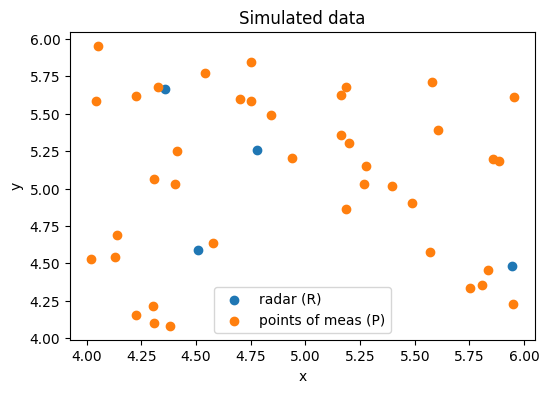

In [212]:
n = 4   # the number of radar locations to estimate
m = 10*n # the number of known locations, from which we record the measurements z_i
c = 0.5

r = get_radar_positions(n) # (2 x n)
p = get_radar_positions(m) # (2 x m)
plot_map(p, r, title="Simulated data")

### 1. Number of needed measurements

A measurement $z_i$ at the known location $(x_i, y_i)$ is given by:

$$z_i = c \sum_{k=1}^{n} \frac{1}{(x_i-u_k)^2 + (y_i-v_k)^2}$$
$$z_i = c \left( \frac{1}{(x_i-u_1)^2 + (y_i-v_1)^2} +  \frac{1}{(x_2-u_k)^2 + (y_2-v_k)^2} + \dots +  \frac{1}{(x_i-u_n)^2 + (y_i-v_n)^2} \right)$$

We can see that this equation has $2n$ unkowns, thus we need at least $m=2n$ measurements. 

In [213]:
def get_measurements(p, r, sensor_noise=1e-3):
    """
    Get the sum of noisy signal strength measurements
    :param p: Points from which we perform the measurements, of shape (2xm)
    :param r: Radar positions, of shape (2xn)
    :return z: Obtained measurements, of shape (mx1)
    """
    signal_mat = np.zeros((p.shape[1], r.shape[1])) # shape: (m x n)

    for i in range(p.shape[1]):
        x_i, y_i = p[:, i].flatten()
        for k in range(r.shape[1]):
            u_k, v_k = r[:, k].flatten()
            signal_mat[i, k] += j(x_i, y_i, u_k, v_k, c)
    
    # Add noise to the measurements
    noise_mat = sensor_noise * np.random.randn(signal_mat.shape[0], signal_mat.shape[1])
    return (signal_mat + noise_mat).sum(axis=1)

### 2. Function to optimize

We are given the following system of non-linear equations:

$$\sum_{k=1}^{n}j_k(x_1, y_1) - z_1 \approx 0 = g_1(u_1, v_1, u_2, v_2, \dots, u_k, v_k)$$
$$\sum_{k=1}^{n}j_k(x_2, y_2) - z_2 \approx 0 = g_2(u_1, v_1, u_2, v_2, \dots, u_k, v_k)$$
$$\vdots$$
$$\sum_{k=1}^{n}j_k(x_m, y_m) - z_m \approx 0 = g_m(u_1, v_1, u_2, v_2, \dots, u_k, v_k)$$

We can combine this into a vector function $G$:

$$G(u_1, v_1, u_2, v_2, \dots, u_k, v_k) = \begin{bmatrix} g_1(u_1, v_1, u_2, v_2, \dots, u_k, v_k) \\  g_2(u_1, v_1, u_2, v_2, \dots, u_k, v_k) \\ \vdots \\ g_m(u_1, v_1, u_2, v_2, \dots, u_k, v_k) \end{bmatrix} \;$$

Finally, we are looking for the parameters $(u_1, v_1, u_2, v_2, \dots, u_k, v_k)$ which solve:

$$G(u_1, v_1, u_2, v_2, \dots, u_k, v_k) = 0$$

In [214]:
def G(p, r, z):
    """Evaluate the system vector function"""
    sys_fun = np.zeros((p.shape[1], ))
    # Iterate over all point of measurement
    for i in range(p.shape[1]):
        x_i, y_i = p[:, i].flatten()
        
        # Iterate over all radars
        for k in range(r.shape[1]):
            u_k, v_k = r[:, k].flatten()
            sys_fun[i] += j(x_i, y_i, u_k, v_k, c)
        sys_fun[i] -= z[i]
    
    return sys_fun

def test_setup(p, r):
    """Check that G(x)=0, when x are the actual radar positions"""
    # compute the measurements
    z = get_measurements(p, r, sensor_noise=0)
    
    # evaluate the function using actual radar positions
    assert G(p, r, z).sum() == 0.0, "Wrong mathematical model?"
    
test_setup(p, r)

### 3. Newton's Method

Newtons method is given by the following algorithm:

$$\text{x}_{k+1} = \text{x}_{k} - D_G(\text{x}_{k})^{+} G(\text{x}_{k})$$

where: $$\text{x}_k = (u_1, v_1, u_2, v_2, \dots, u_m, v_m )^T$$

where $D_G$ is the jacobian, described by:

$$D_G(\text{x}_k) = \begin{bmatrix} \nabla g_1(u_1, v_1, u_2, v_2, \dots, u_k, v_k) \\ \nabla g_2(u_1, v_1, u_2, v_2, \dots, u_k, v_k) \\ \vdots \\ \nabla g_m(u_1, v_1, u_2, v_2, \dots, u_k, v_k)\end{bmatrix} =\begin{bmatrix} \frac{\partial g_1}{\partial u_1}, \frac{\partial g_1}{\partial v_1}, \frac{\partial g_1}{\partial u_2}, \frac{\partial g_1}{\partial v_2}, \dots, \frac{\partial g_1}{\partial u_n}, \frac{\partial g_1}{\partial v_n} \\
\frac{\partial g_2}{\partial u_1}, \frac{\partial g_2}{\partial v_1}, \frac{\partial g_2}{\partial u_2}, \frac{\partial g_2}{\partial v_2}, \dots, \frac{\partial g_2}{\partial u_n}, \frac{\partial g_2}{\partial v_n} \\
\vdots \\
\frac{\partial g_m}{\partial u_1}, \frac{\partial g_m}{\partial v_1}, \frac{\partial g_m}{\partial u_2}, \frac{\partial g_m}{\partial v_2}, \dots, \frac{\partial g_m}{\partial u_n}, \frac{\partial g_m}{\partial v_n} \\
\end{bmatrix}$$

To compute the jacobian $D_G(\text{x})$ we'll need the following derivatives:

$$\frac{\partial g_i}{\partial u_k} = \frac{\partial j_k(x_i, y_i)}{\partial u_k} \ (\forall k = 1 \dots n, \forall i = 1 \dots m)$$
$$\frac{\partial g_i}{\partial v_k} = \frac{\partial j_k(x_i, y_i)}{\partial v_k} \ (\forall k = 1 \dots n, \forall i = 1 \dots m)$$

Which turn out to be:
$$\frac{\partial g_i}{\partial u_k} = \frac{2c(x_i - u_k)}{\left((x_i -u_k)^2 + (y_i - v_k)^2\right)^2}$$
$$\frac{\partial g_i}{\partial v_k} = \frac{2c(y_i - v_k)}{\left((x_i -u_k)^2 + (y_i - v_k)^2\right)^2}$$

In [215]:
def DG(p, r):
    """Compute the Jacobian (DG) of the system function (G)."""
    jacobian = np.zeros((p.shape[1], 2*r.shape[1]))
    
    for i in range(p.shape[1]):
        x_i, y_i = p[:, i].flatten()
        
        for k in range(r.shape[1]):
            u_k, v_k = r[:, k].flatten()
            d_ik = (x_i - u_k)**2 + (y_i - v_k)**2
            jacobian[i, 2*k]   = (2*c*(x_i - u_k))/(d_ik**2)
            jacobian[i, 2*k+1] = (2*c*(y_i - v_k))/(d_ik**2)
    
    return jacobian

In [216]:
def newton(G, DG, p, r_0, z, max_iters, tol):
    """
    Estimate the zeros of the system G(x)=0 using the Newton's method
    :param G: System function
    :param DG: Jacobian matrix of the System function
    :param p: Matrix of known locations, of shape (2 x m)
    :param r_0: Initial estimate of radar locations, of shape (2 x n)
    """
    
    # initialize the paramter vectors
    cols, rows = r_0.shape
    r_f = r_0.T.flatten()
    r_f_ = r_f.copy()
    
    # initilize the error and counter
    err = tol + 1
    k = 0
    
    # apply newton iterations until convergence
    while k < max_iters and err > tol:
        r = r_f.reshape(rows, cols).T
        r_f_ = r_f - np.linalg.pinv(DG(p, r)) @ G(p, r, z)
        # print(r_f_)
        
        # compute the error
        err = np.linalg.norm(r_f_ - r_f)
        r_f = r_f_
        k = k + 1
    
    return r_f.reshape(rows, cols).T    

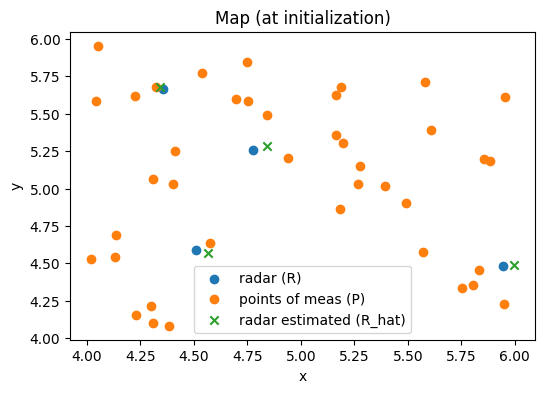

In [221]:
# obtain the measurements
z = get_measurements(p, r, sensor_noise=1e-3)

# initial estimate of the paramters
init_eps = 0.05
r_hat = r.copy() + init_eps * np.random.randn(r.shape[0], r.shape[1]) 
plot_map(p, r, title="Map (at initialization)", r_hat=r_hat)

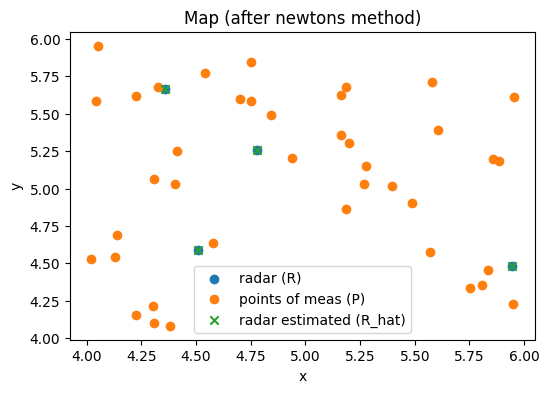

In [222]:
r_hat_final = newton(G, DG, p, r_hat, z, max_iters=100, tol=1e-5)
plot_map(p, r, title="Map (after newtons method)", r_hat=r_hat_final)

### 4. Analysis

We can see that as the number of (noisy) measurements $z_i$ increases, the estimated radar positions improve, however we should point out that the system heavily depends on the quality of initial estimate (of radar positions).

In [273]:
n = 3   
m = 150
c = 0.5

r = get_radar_positions(n) 
p = get_radar_positions(m) 
z = get_measurements(p, r, sensor_noise=1e-3)
init_eps = 0.05
r_hat = r.copy() + init_eps * np.random.randn(r.shape[0], r.shape[1]) 

m_is = list(range(2*n, m, 25))
err_i = []

for m_i in m_is:
    p_idxs = np.random.choice(p.shape[1], size=m_i, replace=False)
    r_hat_final = newton(G, DG, p[:, p_idxs], r_hat, z[p_idxs], max_iters=100, tol=1e-5)
    err = np.sqrt(np.linalg.norm(r_hat_final - r))
    err_i.append(err)    
    # plot_map(p[:, p_idxs], r, title=f"map, m={m_i}, err={err}", r_hat=r_hat_final)    

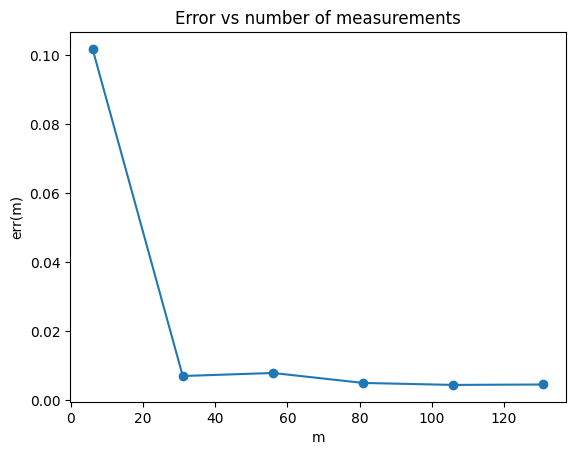

In [274]:
plt.plot(m_is, err_i, "-o")
plt.xlabel("m")
plt.ylabel("err(m)")
plt.title("Error vs number of measurements");